### 필요한 라이브러리 import

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from PIL import Image

from matplotlib import pyplot as plt
import tensorflow as tf

### 이미지 로드

In [2]:
person_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image.png'
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'

img_person = cv2.imread(person_path) 
img_cat = cv2.imread(cat_path)

print(img_person.shape, img_cat.shape)

(381, 740, 3) (641, 620, 3)


### DeepLab 모델 준비

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 사전 정의된 가중치 로드 및 모델 인스턴스화

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel/aiffel/human_segmentation/models
model loaded successfully!


### 이미지 입력

In [5]:
img_resized_person, seg_map_person = MODEL.run(img_person)
print (img_person.shape, img_resized_person.shape, seg_map_person.max())

(381, 740, 3) (264, 513, 3) 18


In [6]:
img_resized_cat, seg_map_cat = MODEL.run(img_cat)
print (img_cat.shape, img_resized_cat.shape, seg_map_cat.max())

(641, 620, 3) (513, 496, 3) 9


### 인물, 고양이 영역 검출

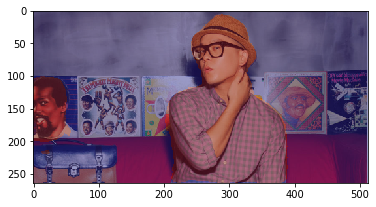

In [7]:
img_show_person = img_resized_person.copy()
seg_map_person = np.where(seg_map_person == 15, 15, 0)
img_mask_person = seg_map_person * (255/seg_map_person.max())
img_mask_person = img_mask_person.astype(np.uint8)
color_mask_person = cv2.applyColorMap(img_mask_person, cv2.COLORMAP_JET)
img_show_person = cv2.addWeighted(img_show_person, 0.6, color_mask_person, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_person, cv2.COLOR_BGR2RGB))
plt.show()

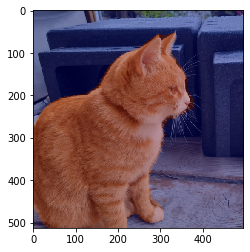

In [8]:
img_show_cat = img_resized_cat.copy()
seg_map_cat = np.where(seg_map_cat == 8, 8, 0)
img_mask_cat = seg_map_cat * (255/seg_map_cat.max()) # 255 normalization
img_mask_cat = img_mask_cat.astype(np.uint8)
color_mask_cat = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
img_show_cat= cv2.addWeighted(img_show_cat, 0.6, color_mask_cat, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 이미지 크기 복원

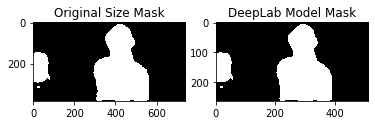

In [9]:
img_mask_up_person = cv2.resize(img_mask_person, img_person.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_person = cv2.threshold(img_mask_up_person, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_person, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_person, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

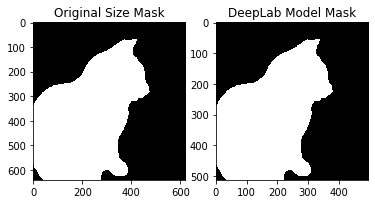

In [10]:
img_mask_up_cat = cv2.resize(img_mask_cat, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_cat, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경 추출

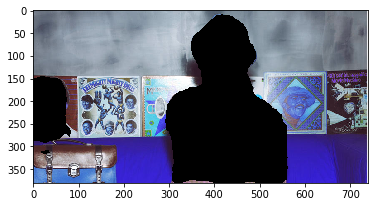

In [11]:
img_mask_color_person = cv2.cvtColor(img_mask_up_person, cv2.COLOR_GRAY2BGR)
img_bg_mask_person = cv2.bitwise_not(img_mask_color_person)
img_bg_person = cv2.bitwise_and(img_person, img_bg_mask_person)
plt.imshow(img_bg_person)
plt.show()

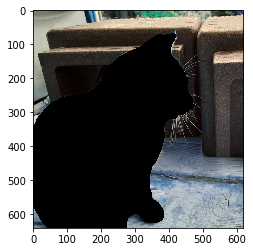

In [12]:
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_cat = cv2.bitwise_and(img_cat, img_bg_mask_cat)
plt.imshow(img_bg_cat)
plt.show()

### 인물 아웃포커싱

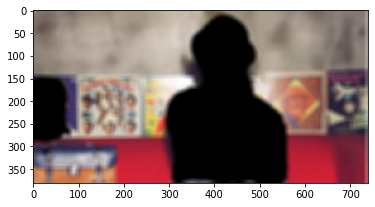

In [13]:
img_bg_blur_person = cv2.blur(img_bg_person, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur_person, cv2.COLOR_BGR2RGB))
plt.show()

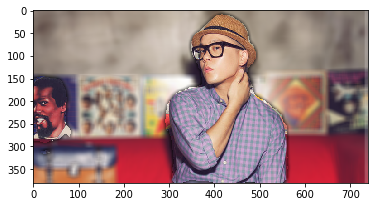

In [37]:
img_concat_person = np.where(img_mask_color_person==255, img_person, img_bg_blur_person)
plt.imshow(cv2.cvtColor(img_concat_person, cv2.COLOR_BGR2RGB))

save_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
cv2.imwrite(save_path + 'person_result.jpg', img_concat_person)
plt.show()

### 고양이 아웃포커싱

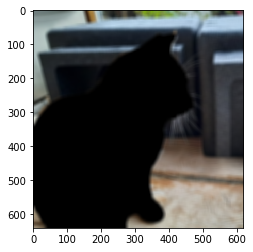

In [15]:
img_bg_blur_cat = cv2.blur(img_bg_cat, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

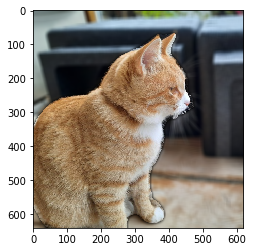

In [38]:
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
cv2.imwrite(save_path + 'cat_result.jpg', img_concat_cat)
plt.show()

### 크로마키

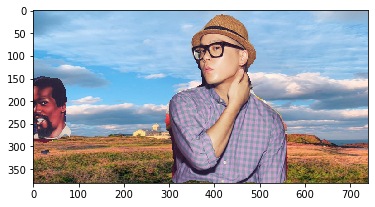

In [46]:
background_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpeg'

img_background = cv2.imread(background_path)
img_background = cv2.resize(img_background, img_mask_up_person.shape[:2][::-1])

img_ck_person = np.where(img_bg_mask_person==0, img_person, img_background)
plt.imshow(cv2.cvtColor(img_ck_person, cv2.COLOR_BGR2RGB))
cv2.imwrite(save_path + 'chroma_key_result.jpg', img_ck_person)
plt.show()

### 인물 사진에서 문제점 찾기

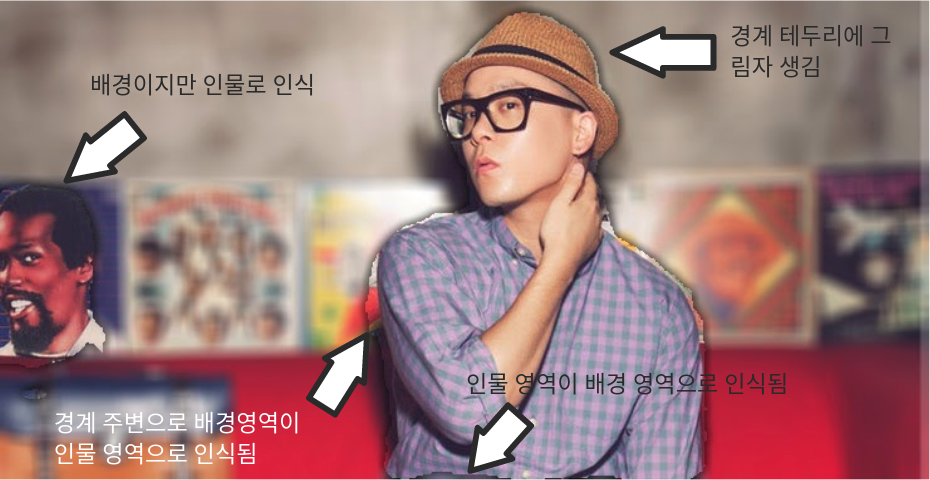